# Lab 2 (Part 2): Regularizing MLPs

José María Martínez Marín 100443343

Azamat Ziiadinov 100460540


------------------------------------------------------
*Deep Learning. Master in Big Data Analytics*

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this second part of the lab, ou'll be using the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist), a drop-in replacement for the MNIST dataset. MNIST is actually quite trivial with neural networks where you can easily achieve better than 97% accuracy. Fashion-MNIST is a set of 28x28 greyscale images of clothes. It's more complex than MNIST, so it's a better representation of the actual performance of your network, and a better representation of datasets you'll use in the real world. You can see a sample below.

In [ ]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

Our goal is to build a neural network that can take one of these images and predict the digit in the image. Unlike the MNIST case, for this problem you will notice that the model **easily overfits**, so addressing this issue is an important problem here. To do so, we will experiment with early stopping, dropout, and L2 weight regularization.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [ ]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw



Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:479: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Lets take a look to the mini-batch size and plot a sample.

In [ ]:
dataiter = iter(trainloader)   #To iterate through the dataset

images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

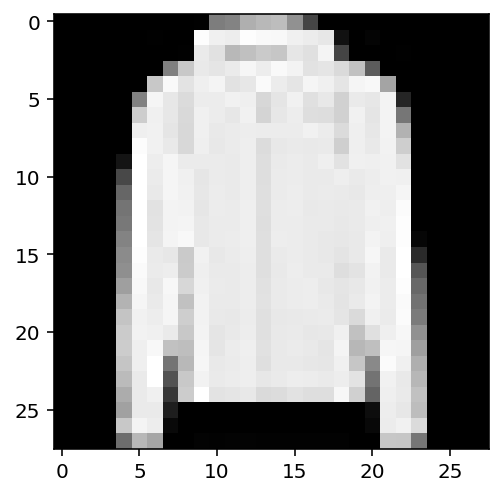

In [ ]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='Greys_r')

## Part II. Visualize overfiting

> **Exercise**: Train a Neural Network with four layers, hidden dimmensions 256, 128 and 64 neurons. Use ReLU activation functions, and a log-Softmax output layer. To do so, complete the following steps: 
> - Create a class defining the NN model 
> - Extend the class to incorporate a training method. **Call it trainloop instead of train**. The reason will be clear later.
> - Train the model for 30 epochs and evaluate train/test performance

In [ ]:
class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [ ]:
class MLP_extended(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize MLP!
        
        self.lr = lr #Learning Rate      
        self.optim = optim.Adam(self.parameters(), self.lr)       
        self.epochs = epochs       
        self.criterion = nn.NLLLoss()
        
        # A list to store the loss evolution along training
        self.loss_during_training = [] 
        
        
    def trainloop(self,loader):     
        # Adam Loop  
        for e in range(int(self.epochs)): 
            running_loss = 0.

            for (images, labels) in trainloader:            
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()
      
            self.loss_during_training.append(running_loss/len(trainloader))

            if(e % 1 == 0): # Every 10 epochs 
                      print("Training loss after %d iterations: %f" 
                      %(e,self.loss_during_training[-1]))
                
    def accuracy(self, loader):
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          for (images, labels) in loader:
            logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, to get log-probabilities
            top_p, top_class = logprobs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1))
            accuracy += torch.mean(equals.type(torch.FloatTensor))              
        print("Accuracy %f" %(accuracy/len(loader)))
        return accuracy/len(loader)
         # print(f'The accuracy in the {part} dataset is: {accuracy/len(loader)}')

In [ ]:
#YOUR CODE HERE

my_MLP = MLP_extended(dimx = 784, hidden1 = 256, hidden2 = 128, hidden3 = 64, nlabels = 10, 
                   epochs = 30, lr = 1e-3)
my_MLP.trainloop(trainloader)

print("Train Accuracy %f" %(my_MLP.accuracy(trainloader)))
print("Test Accuracy %f" %(my_MLP.accuracy(testloader)))

Training loss after 0 iterations: 0.514332
Training loss after 1 iterations: 0.376515
Training loss after 2 iterations: 0.337254
Training loss after 3 iterations: 0.314028
Training loss after 4 iterations: 0.295707
Training loss after 5 iterations: 0.279895
Training loss after 6 iterations: 0.265196
Training loss after 7 iterations: 0.254273
Training loss after 8 iterations: 0.241896
Training loss after 9 iterations: 0.229161
Training loss after 10 iterations: 0.221586
Training loss after 11 iterations: 0.213028
Training loss after 12 iterations: 0.202687
Training loss after 13 iterations: 0.194322
Training loss after 14 iterations: 0.184308
Training loss after 15 iterations: 0.177330
Training loss after 16 iterations: 0.171347
Training loss after 17 iterations: 0.165421
Training loss after 18 iterations: 0.159635
Training loss after 19 iterations: 0.149614
Training loss after 20 iterations: 0.149128
Training loss after 21 iterations: 0.142171
Training loss after 22 iterations: 0.13640

In light of the train/test performance, certainly the model is performing significantly better in the train set than in the test set. This is a sign of overfitting. For an early detection of overfitting, we will make use of a **validation set** that we will use to visualize the evolution of the loss function during training. 

With the following code we split the train set into one training set (45k images) and a validation set (15k images). We do a naive splitting assuming that the data is randomized. **Keep in mind that in general you can do something smarter than this like K-Fold cross validation**, but here we keep it simple.



In [ ]:
import copy


validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]



> **Exercise**: Modify your code class above so that, during training, everytime an epoch is finished you compute the loss function over the validation set. You must store these values into a list name as `valid_loss_during_training`. When performing this step, do not forget to turn off gradients by using `with torch.no_grad()`.
>
>Then, repeat the training (30 epochs) and plot the train/validation loss along epochs. Compute the final train/validation/test performance.

In [ ]:
#YOUR CODE HERE

class MLP_extended_2(MLP):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):   
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize MLP!      
        self.lr = lr #Learning Rate      
        self.optim = optim.Adam(self.parameters(), self.lr)      
        self.epochs = epochs       
        self.criterion = nn.NLLLoss()    
        self.loss_during_training = []
        # A list to store the loss evolution along validation    
        self.valid_loss_during_training = [] 

    def valid_loss(self, validloader): 
        if validloader is not None:  
            with torch.no_grad():
                running_loss = 0.    
                for (images, labels) in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()    
                self.valid_loss_during_training.append(running_loss/len(validloader))    
        else:  
            raise ValueError('validloader must contain data.')        
          
    def trainloop(self,trainloader,validloader = None):     
        # Adam Loop     
        for e in range(int(self.epochs)):      
            running_loss = 0.

            for images, labels in trainloader:             
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))             
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()       

            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                self.valid_loss(validloader)

            if(e % 1 == 0): # Every 1 epochs              
                print("Training loss after %d iterations: %f" 
                      %(e,self.loss_during_training[-1]))              
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))           

    def accuracy(self, loader):     
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          for (images, labels) in loader:
            logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, to get log-probabilities
            top_p, top_class = logprobs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1))
            accuracy += torch.mean(equals.type(torch.FloatTensor))     
        return accuracy/len(loader)  
        

In [ ]:


my_MLP_2 = MLP_extended_2(dimx=784, hidden1=256,hidden2=128, hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP_2.trainloop(trainloader, validloader)

print("Train Accuracy %f" %(my_MLP_2.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_2.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_2.accuracy(testloader)))

Training loss after 0 iterations: 0.544167
Validation loss after 0 epochs: 0.481442
Training loss after 1 iterations: 0.393214
Validation loss after 1 epochs: 0.374740
Training loss after 2 iterations: 0.356927
Validation loss after 2 epochs: 0.363331
Training loss after 3 iterations: 0.324524
Validation loss after 3 epochs: 0.330733
Training loss after 4 iterations: 0.302071
Validation loss after 4 epochs: 0.343655
Training loss after 5 iterations: 0.289807
Validation loss after 5 epochs: 0.325672
Training loss after 6 iterations: 0.274117
Validation loss after 6 epochs: 0.331159
Training loss after 7 iterations: 0.260916
Validation loss after 7 epochs: 0.340316
Training loss after 8 iterations: 0.248810
Validation loss after 8 epochs: 0.328825
Training loss after 9 iterations: 0.235614
Validation loss after 9 epochs: 0.326862
Training loss after 10 iterations: 0.224128
Validation loss after 10 epochs: 0.348474
Training loss after 11 iterations: 0.214733
Validation loss after 11 epoch

Text(0, 0.5, 'Loss Functions')

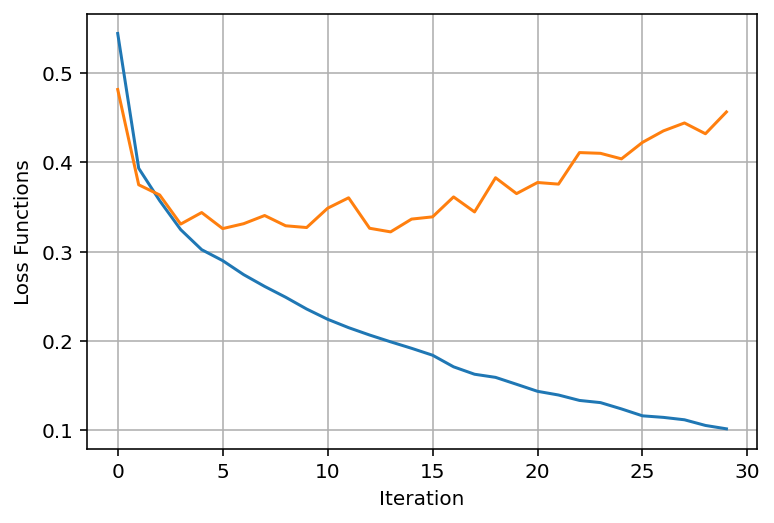

In [ ]:
plt.plot(my_MLP_2.loss_during_training)
plt.plot(my_MLP_2.valid_loss_during_training)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss Functions')

As can be seen from the previous plot, early stopping at a number of 8 epochs would prevent the model from overfitting, as from there the validation loss function starts increasing.

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting. 

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you'd save the model frequently as you're training then later choose the model with the lowest validation loss. **Note that with early stopping we are using the validation set to select the appropiate number of epochs.**

> **Exercise:** According to your results, re-train the model again for the right number of epochs (just before the validation loss starts to grow). Compare the train, validation and test performance.

In [ ]:
#YOUR CODE HERE

#Number of epochs is 5

my_MLP_2 = MLP_extended_2(dimx = 784, hidden1 = 256, hidden2 = 128, hidden3 = 64, nlabels = 10, 
                       epochs = 8, lr = 1e-3)
my_MLP_2.trainloop(trainloader, validloader)



print("Train Accuracy %f" %(my_MLP_2.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_2.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_2.accuracy(testloader)))

Training loss after 0 iterations: 0.549523
Validation loss after 0 epochs: 0.460250
Training loss after 1 iterations: 0.390400
Validation loss after 1 epochs: 0.390447
Training loss after 2 iterations: 0.352947
Validation loss after 2 epochs: 0.382386
Training loss after 3 iterations: 0.322489
Validation loss after 3 epochs: 0.362472
Training loss after 4 iterations: 0.303717
Validation loss after 4 epochs: 0.338099
Training loss after 5 iterations: 0.283516
Validation loss after 5 epochs: 0.350386
Training loss after 6 iterations: 0.270495
Validation loss after 6 epochs: 0.348970
Training loss after 7 iterations: 0.257947
Validation loss after 7 epochs: 0.344418
Train Accuracy 0.907604
Valid Accuracy 0.877128
Test Accuracy 0.874005


The train performance is slightly better than the validation and the test ones, nevertheless, both accuracies are quite high (above 87.5%), showing an appropriate performance of the sets.

## Part III. Using Dropout Regularization

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing it's ability to generalize to new data. Adding dropout in PyTorch is straightforward using the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

The following code corresponds to a 2 layer NN where we use dropout in the intermediate hidden space:


```python
class MLP_dropout(nn.Module):
    def __init__(self,dimx,hidden1,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)  
        
        self.output2 = nn.Linear(hidden1,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)  
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.logsoftmax(x) #YOUR CODE HERE
        return x

```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing, and whenever we're using the network to make predictions. To do this, you use `self.eval()`. This sets the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `self.train()` (**This is why we cannot call our training method `train` anymore**). In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():
    
    # set model to evaluation mode
    self.eval()
    
    # validation pass here
    for images, labels in testloader:
        ...

# set model back to train mode
self.train()
```

> **Exercise:** 
> - Create a new NN class that modifies the previous one by incorporating a dropout step with `p=0.2`  after every ReLU non-linearity is applied. 
> - Modified the extended clases to set `model.eval()` when appropiate (do not forget to go back to `model.train()`)
> - For this new model, plot the evolution of the training and validation losses. Compare with the case with no dropout. Discuss the results. Is early stopping still required? If so, when you should stop training? Compare the train, validation and test performance.
> - Repeat the experiments for a dropout probability of `p=0.1` and `p=0.3`. Which value provides the best validation performance? 

In [ ]:
class MLP_drop(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        self.output1 = nn.Linear(dimx,hidden1)      
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)        
        self.output4 = nn.Linear(hidden3,nlabels)    
        self.relu = nn.ReLU()        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [ ]:
class MLPdrop_extended(MLP_drop):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):    
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize MLP!     
        self.lr = lr #Learning Rate   
        self.optim = optim.Adam(self.parameters(), self.lr)      
        self.epochs = epochs     
        self.criterion = nn.NLLLoss()       
        self.loss_during_training = [] # Store the loss evolution along training
        # A list to store the loss evolution along validation        
        self.valid_loss_during_training = [] 
        
    def valid_loss(self, validloader):
        if validloader is not None:
            with torch.no_grad():
                self.eval()
                running_loss = 0.
                for (images, labels) in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()
                self.valid_loss_during_training.append(running_loss/len(validloader))
        else:
            raise ValueError('validloader must contain data.')

    # set model back to train mode
        self.train() 

    def trainloop(self,trainloader, validloader = None):       
        # Adam Loop        
        for e in range(int(self.epochs)):     
            running_loss = 0.
            for images, labels in trainloader:           
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))                
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()       
            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                self.valid_loss(validloader)

            if(e % 1 == 0): # Every 10 epochs               
                print("Training loss after %d iterations: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))  
                
    def accuracy(self, loader):     
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          for (images, labels) in loader:
            logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, to get log-probabilities
            top_p, top_class = logprobs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1))
            accuracy += torch.mean(equals.type(torch.FloatTensor))     
        return accuracy/len(loader)         

In [ ]:
#YOUR CODE HERE

my_MLP_drop = MLPdrop_extended(dimx=784, hidden1=256,hidden2=128, hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP_drop.trainloop(trainloader, validloader)

print("Train Accuracy %f" %(my_MLP_drop.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_drop.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_drop.accuracy(testloader)))

Training loss after 0 iterations: 0.634693
Validation loss after 0 epochs: 0.449188
Training loss after 1 iterations: 0.452535
Validation loss after 1 epochs: 0.409891
Training loss after 2 iterations: 0.411154
Validation loss after 2 epochs: 0.377146
Training loss after 3 iterations: 0.391053
Validation loss after 3 epochs: 0.389533
Training loss after 4 iterations: 0.364889
Validation loss after 4 epochs: 0.351285
Training loss after 5 iterations: 0.357609
Validation loss after 5 epochs: 0.374423
Training loss after 6 iterations: 0.341022
Validation loss after 6 epochs: 0.349320
Training loss after 7 iterations: 0.332215
Validation loss after 7 epochs: 0.335907
Training loss after 8 iterations: 0.318118
Validation loss after 8 epochs: 0.332433
Training loss after 9 iterations: 0.313914
Validation loss after 9 epochs: 0.333122
Training loss after 10 iterations: 0.304438
Validation loss after 10 epochs: 0.333291
Training loss after 11 iterations: 0.292152
Validation loss after 11 epoch

Text(0, 0.5, 'Loss Function for p=0.2 Dropout')

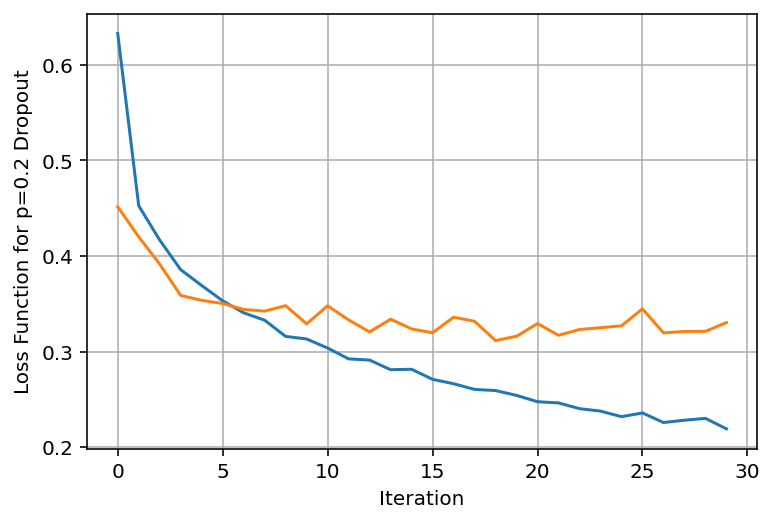

In [ ]:
plt.plot(my_MLP_drop.loss_during_training)
plt.plot(my_MLP_drop.valid_loss_during_training)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss Functions for p=0.2 Dropout')

It can be seen that the optimal number of epochs is 8, as from there, there is no big improvement in terms of loss function for the validation set. Contrary to the case with no dropout, in this case the validation loss function continues decreasing, but from the 8th iteration it stabilizes, so that the decrease from there to the last iteration is only of a 3.5%, and from the 8th iteration to the lowest peak, at 19th iteration, is of a 9.9%.

In [ ]:
# Repeat for 8 epochs

my_MLP_drop = MLPdrop_extended(dimx=784, hidden1=256,hidden2=128, hidden3=64,nlabels=10,epochs=8,lr=1e-3)

my_MLP_drop.trainloop(trainloader, validloader)

print("Train Accuracy %f" %(my_MLP_drop.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_drop.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_drop.accuracy(testloader)))

Training loss after 0 iterations: 0.645154
Validation loss after 0 epochs: 0.456079
Training loss after 1 iterations: 0.454310
Validation loss after 1 epochs: 0.390771
Training loss after 2 iterations: 0.412767
Validation loss after 2 epochs: 0.379726
Training loss after 3 iterations: 0.384978
Validation loss after 3 epochs: 0.363908
Training loss after 4 iterations: 0.368043
Validation loss after 4 epochs: 0.373454
Training loss after 5 iterations: 0.349757
Validation loss after 5 epochs: 0.360148
Training loss after 6 iterations: 0.337531
Validation loss after 6 epochs: 0.356753
Training loss after 7 iterations: 0.327867
Validation loss after 7 epochs: 0.330901
Train Accuracy 0.890004
Valid Accuracy 0.871609
Test Accuracy 0.858678


In [ ]:
#YOUR CODE HERE

#For Dropout p=0.1

class MLP_drop2(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        self.output1 = nn.Linear(dimx,hidden1)       
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)      
        self.output4 = nn.Linear(hidden3,nlabels)   
        self.relu = nn.ReLU()       
        self.logsoftmax = nn.LogSoftmax(dim=1)
        # Dropout module with 0.1 drop probability
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x


In [ ]:
#YOUR CODE HERE

class MLPdrop2_extended(MLP_drop2):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):    
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize MLP!     
        self.lr = lr #Learning Rate   
        self.optim = optim.Adam(self.parameters(), self.lr)      
        self.epochs = epochs     
        self.criterion = nn.NLLLoss()       
        self.loss_during_training = [] # Store the loss evolution along training
        # A list to store the loss evolution along validation        
        self.valid_loss_during_training = [] 
        
    def valid_loss(self, validloader):
        if validloader is not None:
            with torch.no_grad():
                self.eval()
                running_loss = 0.
                for (images, labels) in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()
                self.valid_loss_during_training.append(running_loss/len(validloader))
        else:
            raise ValueError('validloader must contain data.')

    # set model back to train mode
        self.train() 

    def trainloop(self,trainloader, validloader = None):       
        # Adam Loop        
        for e in range(int(self.epochs)):     
            running_loss = 0.
            for images, labels in trainloader:           
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))                
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()       
            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                self.valid_loss(validloader)

            if(e % 1 == 0): # Every epoch             
                print("Training loss after %d iterations: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))                

    def accuracy(self, loader):     
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          for (images, labels) in loader:
            logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, to get log-probabilities
            top_p, top_class = logprobs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1))
            accuracy += torch.mean(equals.type(torch.FloatTensor))     
        return accuracy/len(loader)         


In [ ]:
my_MLP_drop2 = MLPdrop2_extended(dimx=784, hidden1=256,hidden2=128, hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP_drop2.trainloop(trainloader, validloader)

print("Train Accuracy %f" %(my_MLP_drop2.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_drop2.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_drop2.accuracy(testloader)))

Training loss after 0 iterations: 0.605415
Validation loss after 0 epochs: 0.455607
Training loss after 1 iterations: 0.422618
Validation loss after 1 epochs: 0.400979
Training loss after 2 iterations: 0.378812
Validation loss after 2 epochs: 0.368959
Training loss after 3 iterations: 0.355323
Validation loss after 3 epochs: 0.356547
Training loss after 4 iterations: 0.333373
Validation loss after 4 epochs: 0.360132
Training loss after 5 iterations: 0.322699
Validation loss after 5 epochs: 0.344254
Training loss after 6 iterations: 0.308846
Validation loss after 6 epochs: 0.324496
Training loss after 7 iterations: 0.293989
Validation loss after 7 epochs: 0.327776
Training loss after 8 iterations: 0.280912
Validation loss after 8 epochs: 0.327510
Training loss after 9 iterations: 0.273192
Validation loss after 9 epochs: 0.367489
Training loss after 10 iterations: 0.268308
Validation loss after 10 epochs: 0.326711
Training loss after 11 iterations: 0.258243
Validation loss after 11 epoch

Text(0, 0.5, 'Loss Functions for p=0.1 Dropout')

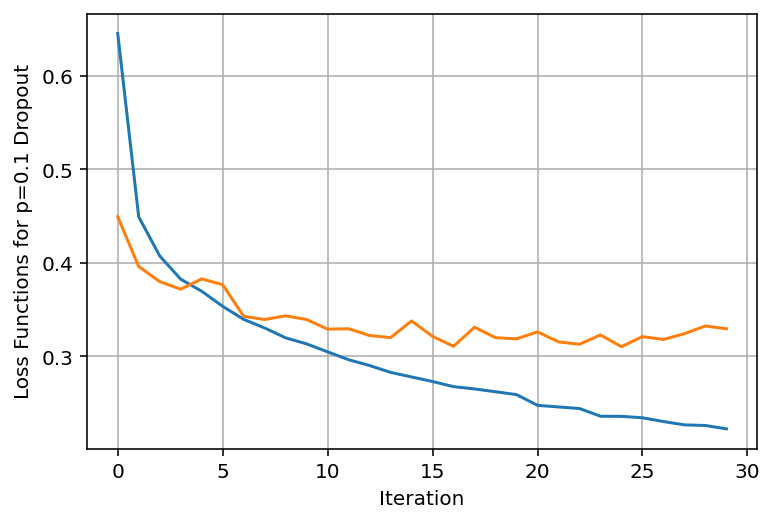

In [ ]:
plt.plot(my_MLP_drop2.loss_during_training)
plt.plot(my_MLP_drop2.valid_loss_during_training)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss Functions for p=0.1 Dropout')

Thus, the optimal number of epochs is 17, in order to avoid overfitting.

In [ ]:
#Repeat the process for 17 epochs

my_MLP_drop2 = MLPdrop2_extended(dimx=784, hidden1=256,hidden2=128, hidden3=64,nlabels=10,epochs=17,lr=1e-3)

my_MLP_drop2.trainloop(trainloader, validloader)

print("Train Accuracy %f" %(my_MLP_drop2.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_drop2.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_drop2.accuracy(testloader)))

Training loss after 0 iterations: 0.600397
Validation loss after 0 epochs: 0.436796
Training loss after 1 iterations: 0.426776
Validation loss after 1 epochs: 0.412265
Training loss after 2 iterations: 0.384772
Validation loss after 2 epochs: 0.374923
Training loss after 3 iterations: 0.356209
Validation loss after 3 epochs: 0.358553
Training loss after 4 iterations: 0.337675
Validation loss after 4 epochs: 0.357674
Training loss after 5 iterations: 0.320032
Validation loss after 5 epochs: 0.336293
Training loss after 6 iterations: 0.305394
Validation loss after 6 epochs: 0.332563
Training loss after 7 iterations: 0.294009
Validation loss after 7 epochs: 0.332704
Training loss after 8 iterations: 0.285342
Validation loss after 8 epochs: 0.361682
Training loss after 9 iterations: 0.276618
Validation loss after 9 epochs: 0.328503
Training loss after 10 iterations: 0.266012
Validation loss after 10 epochs: 0.324888
Training loss after 11 iterations: 0.258551
Validation loss after 11 epoch

**For Dropout p = 0.3**

In [ ]:
#For Dropout p=0.3

class MLP_drop3(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): #Nlabels will be 10 in our case
        super().__init__()
        self.output1 = nn.Linear(dimx,hidden1)     
        self.output2 = nn.Linear(hidden1,hidden2)
        self.output3 = nn.Linear(hidden2,hidden3)       
        self.output4 = nn.Linear(hidden3,nlabels)   
        self.relu = nn.ReLU()       
        self.logsoftmax = nn.LogSoftmax(dim=1)
        # Dropout module with 0.3 drop probability
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x



In [ ]:
class MLPdrop3_extended(MLP_drop3):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):    
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize MLP!     
        self.lr = lr #Learning Rate   
        self.optim = optim.Adam(self.parameters(), self.lr)      
        self.epochs = epochs     
        self.criterion = nn.NLLLoss()       
        self.loss_during_training = [] # Store the loss evolution along training
        # A list to store the loss evolution along validation        
        self.valid_loss_during_training = [] 
        
    def valid_loss(self, validloader):
        if validloader is not None:
            with torch.no_grad():
                self.eval()
                running_loss = 0.
                for (images, labels) in validloader:
                    out = self.forward(images.view(images.shape[0], -1))
                    loss = self.criterion(out, labels)
                    running_loss += loss.item()
                self.valid_loss_during_training.append(running_loss/len(validloader))
        else:
            raise ValueError('validloader must contain data.')

    # set model back to train mode
        self.train() 

    def trainloop(self,trainloader, validloader = None):       
        # Adam Loop        
        for e in range(int(self.epochs)):     
            running_loss = 0.
            for images, labels in trainloader:           
                self.optim.zero_grad()  #TO RESET GRADIENTS!
                out = self.forward(images.view(images.shape[0], -1))                
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()       
            self.loss_during_training.append(running_loss/len(trainloader))
            if validloader is not None:
                self.valid_loss(validloader)

            if(e % 1 == 0): # Every epoch             
                print("Training loss after %d iterations: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))                

    def accuracy(self, loader):     
        accuracy = 0
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
          for (images, labels) in loader:
            logprobs = self.forward(images.view(images.shape[0], -1)) # We use a log-softmax, to get log-probabilities
            top_p, top_class = logprobs.topk(1, dim=1)
            equals = (top_class == labels.view(images.shape[0], 1))
            accuracy += torch.mean(equals.type(torch.FloatTensor))     
        return accuracy/len(loader)             

In [ ]:
my_MLP_drop3 = MLPdrop3_extended(dimx=784, hidden1=256,hidden2=128, hidden3=64,nlabels=10,epochs=30,lr=1e-3)

my_MLP_drop3.trainloop(trainloader, validloader)

print("Train Accuracy %f" %(my_MLP_drop3.accuracy(trainloader)))
print("Valid Accuracy %f" %(my_MLP_drop3.accuracy(validloader)))
print("Test Accuracy %f" %(my_MLP_drop3.accuracy(testloader)))

Training loss after 0 iterations: 0.699132
Validation loss after 0 epochs: 0.448783
Training loss after 1 iterations: 0.486192
Validation loss after 1 epochs: 0.409451
Training loss after 2 iterations: 0.448321
Validation loss after 2 epochs: 0.413890
Training loss after 3 iterations: 0.425489
Validation loss after 3 epochs: 0.383896
Training loss after 4 iterations: 0.403134
Validation loss after 4 epochs: 0.359714
Training loss after 5 iterations: 0.387921
Validation loss after 5 epochs: 0.359295
Training loss after 6 iterations: 0.376190
Validation loss after 6 epochs: 0.354771
Training loss after 7 iterations: 0.363802
Validation loss after 7 epochs: 0.354863
Training loss after 8 iterations: 0.362027
Validation loss after 8 epochs: 0.354258
Training loss after 9 iterations: 0.350655
Validation loss after 9 epochs: 0.345600
Training loss after 10 iterations: 0.342160
Validation loss after 10 epochs: 0.338089
Training loss after 11 iterations: 0.337256
Validation loss after 11 epoch

Text(0, 0.5, 'Loss Functions for p=0.3 Dropout')

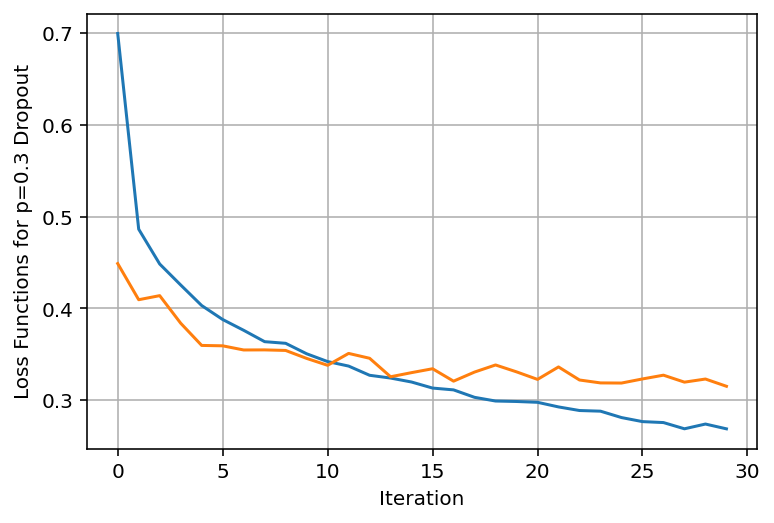

In [ ]:
plt.plot(my_MLP_drop3.loss_during_training)
plt.plot(my_MLP_drop3.valid_loss_during_training)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Loss Functions for p=0.3 Dropout')

From this plot, it can be infered that both losses are the same, and have a decreasing trend, therefore, is does not make sense to use early stopping

As can be seen, the best results are given for p = 0.2, while for p = 0.3 and p = 0.1, the results are fairly similar, with quite high accuracies greater than 84% in every case. However, in the case for p = 0.1, the validation accuracy is higher than the train one, and this fact does not happen with p = 0.3 or p = 0.2